# Practical machine learning and deep learning. Lab 11

# Diffusion Models

## No competition on this lab!

## Contents

* What are Diffusion Models?
* Possible Applications of Diffusion Models
* Advantages over Other Models
* Types of Diffusion Models
* Denoising Diffusion Probabilistic Model (DDPM)
* PyTorch Implementation of DDPM
* Diffusers Impelmentation of DDPM

## What are Diffusion models?

Diffusion models are a class of generative models that have gained popularity for their ability to produce high-quality images and other complex data types. They work by modeling the process of diffusion, which involves gradually transforming a simple initial distribution (usually Gaussian noise) into a more complex target distribution (such as the distribution of real images).

![](https://aisholar.s3.ap-northeast-1.amazonaws.com/post_images/0e26e90d25bc847eed6e7eb6564522b0.png)

Model architectures based on diffusion:
* DALLE
* GLIDE
* Imagen
* Stable Diffusion
* Midjourney
* Kandinsky

## Possible Applications of Diffusion Models

Diffusion models have a wide range of applications across various fields due to their ability to generate high-quality data:

* Image Generation
* Video Generation
* Audio Synthesis
* Molecular Generation
* 3D Object Generation
* Inpainting / Outpainting
* etc...

## Advantages over Other Models

Diffusion models offer several advantages over traditional generative models like Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs):

* Improved stability during training
* Learning complex data patterns
* Less sensitive to hyperparameter tuning
* Generated samples diversity
* Interpretability

## Types of Diffusion Models

* **Denoising Diffusion Probabilistic Models (DDPM)**

    [Proposed by Jonathan Ho et al. in 2020](https://arxiv.org/pdf/2006.11239), DDPMs are among the first successful implementations of diffusion models. They define a forward process that progressively adds noise to data and a reverse process that learns to denoise it, ultimately generating high-quality images.

* **Score-Based Generative Models (SGM)**

    These models, introduced by Yang Song and Stefano Ermon, leverage score matching to estimate the gradients of the data distribution. The models can generate samples by following the learned score functions through a diffusion-like process.

* **Stochastic Differential Equation (SDE) Formulation**

    Song et al. unified DDPMs and SGMs under a broader SDE framework. This allows viewing the diffusion process as a continuous stochastic differential equation rather than discrete steps.

* **Latent Diffusion Models (LDM)**

    LDMs operate in a lower-dimensional latent space instead of pixel space, making them more efficient in terms of computation and memory usage. This approach allows for faster sampling and higher-quality outputs, as seen in models like Stable Diffusion.

In today's lab we will focus on Denoising Diffusion Probabilistic Models (DDPMs) since they are the most prominent.

## Denoising Diffusion Probabilistic Model (DDPM)

### Process

The general process of a diffusion model consists of the two parts: **forward diffusion process** and **reverse denoising process**. Now, let us consider these processes in details.

![](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-forward_and_backward_equations.png)

### Forward Diffusion Process (Adding Noise)

In the forward process, we take a real data sample $x_0$ and gradually add Gaussian noise over a series of $T$ time steps to produce noisy samples $x_1, x_2, \dots, x_T$. By the final time step $T$, the sample has been transformed into nearly pure Gaussian noise. The forward process is defined as a Markov chain, where each step $t \rightarrow t+1$ adds a small amount of noise to the sample.

The transition at each time step is given by:

$$
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \, x_{t-1}, \beta_t I)
$$

where:
- $\beta_t$ is the noise variance schedule, typically a small value that increases with $t$ to ensure gradual diffusion,
- $\sqrt{1 - \beta_t}$ scales down $x_{t-1}$, and
- $\beta_t I$ controls the amount of Gaussian noise added.

The forward diffusion process over multiple steps from $x_0$ to $x_t$ can be expressed as:

$$
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} \, x_0, (1 - \bar{\alpha}_t) I)
$$

where:
- $\alpha_t = 1 - \beta_t$, and
- $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ represents the cumulative product of $\alpha_t$ over all steps up to $t$.

This allows us to directly sample $x_t$ from $x_0$ without calculating each intermediate step individually. A noisy sample $x_t$ can be generated as:

$$
x_t = \sqrt{\bar{\alpha}_t} \, x_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon
$$

where $\epsilon \sim \mathcal{N}(0, I)$ is standard Gaussian noise. This reparameterization is key to both training and sampling in DDPM.

### Reverse Diffusion Process (Denoising)

The reverse process involves learning to gradually denoise each noisy sample $x_t$, moving backwards through the time steps from $t = T$ to $t = 0$. This is also defined as a Markov chain, and the goal is to approximate the reverse transition probability $q(x_{t-1} | x_t)$ with a learned model $p_\theta(x_{t-1} | x_t)$.

The reverse step is defined by a Gaussian distribution:

$$
p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

where:
- $\mu_\theta(x_t, t)$ is the model's predicted mean, which estimates the denoised sample at each step,
- $\Sigma_\theta(x_t, t)$ is the variance, which can be either learned or fixed.

For simplicity, the variance is often chosen to match the forward process's variance, $\Sigma_\theta(x_t, t) = \beta_t I$. This leads to the expression:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon_\theta(x_t, t) \right) + \sqrt{\beta_t} \, z
$$

where:
- $\epsilon_\theta(x_t, t)$ is the model’s prediction of the noise component at step $t$, and
- $z \sim \mathcal{N}(0, I)$ for stochastic sampling (optional for some implementations).

This reverse sampling procedure is iterated from $t = T$ down to $t = 0$ to yield the final generated sample $x_0$.

### Training and Sampling Algorithms

![](https://i.imgur.com/S7KH5hZ.png)

### Network Architecture

Diffusion models often use U-Net architectures with ResNet blocks and
self-attention layers to represent the noise

![](https://miro.medium.com/v2/resize:fit:1400/1*vbYC9E8-hi_76lB4d1BvYg.png)

Time is represented by sinusoidal positional embeddings or random Fourier features. Time features are fed to the residual blocks using either simple spatial addition or using adaptive group normalization layers.

## PyTorch Implementation of DDPM

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from torch.optim import Adam

import math

Model hyperparameters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = (28, 28, 1) # (width, height, channels)

# Define image dimensions and diffusion model parameters
img_size = (28, 28, 1)  # image dimensions: width, height, channels
timestep_embedding_dim = 256  # dimensionality of timestep embedding
n_layers = 8  # number of layers in the model
hidden_dim = 256  # hidden layer size
n_timesteps = 1000  # total diffusion timesteps
beta_minmax = [1e-4, 2e-2]  # min and max beta values for linear schedule
seed = 1234  # seed for reproducibility

# Define hidden dimensions for model layers
hidden_dims = [hidden_dim for _ in range(n_layers)]

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)

Loading dataset

In [ ]:
# Load the MNIST dataset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize training and test datasets with defined transforms
train_dataset = MNIST('./data', transform=transform, train=True, download=True)
test_dataset  = MNIST('./data', transform=transform, train=False, download=True)

# Define batch sizes
train_batch_size = 128
inference_batch_size = 64

# Create DataLoader for training and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=inference_batch_size, shuffle=False)

### Forward Diffusion Process

We need to generate the inputs for our model, consisting of increasingly noisy images. Rather than processing these sequentially, we can utilize the closed-form solutions presented in the papers to compute the image for each timestep independently.

In [ ]:
import torch.nn.functional as F

# Define a function for linearly spaced beta schedule over given timesteps
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

# Utility function to retrieve values from a list based on the timestep index
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    # Select values for each element in batch using timestep index `t`
    out = vals.gather(-1, t.cpu())
    # Reshape the output to match the input tensor shape
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# Function to perform forward diffusion by adding noise to an initial sample
def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)  # Generate random noise matching the shape of input sample
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)  # Scale factor for mean
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)  # Scale factor for variance
    # Compute forward diffusion as `mean + variance * noise`
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define the number of timesteps in the diffusion process
T = 300

# Generate a linearly spaced beta schedule for the diffusion process
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate terms for closed-form diffusion equations
alphas = 1. - betas  # Compute alpha values as 1 minus beta
alphas_cumprod = torch.cumprod(alphas, axis=0)  # Calculate cumulative product of alphas
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # Pad cumulative alphas with 1 at the start for initial state
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)  # Compute square root of reciprocal alphas for denoising steps
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)  # Square root of cumulative alphas for scaling the input image
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)  # Square root of 1 minus cumulative alphas for scaling noise
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)  # Posterior variance for reverse process calculations

Let's visualize the forward diffusion process

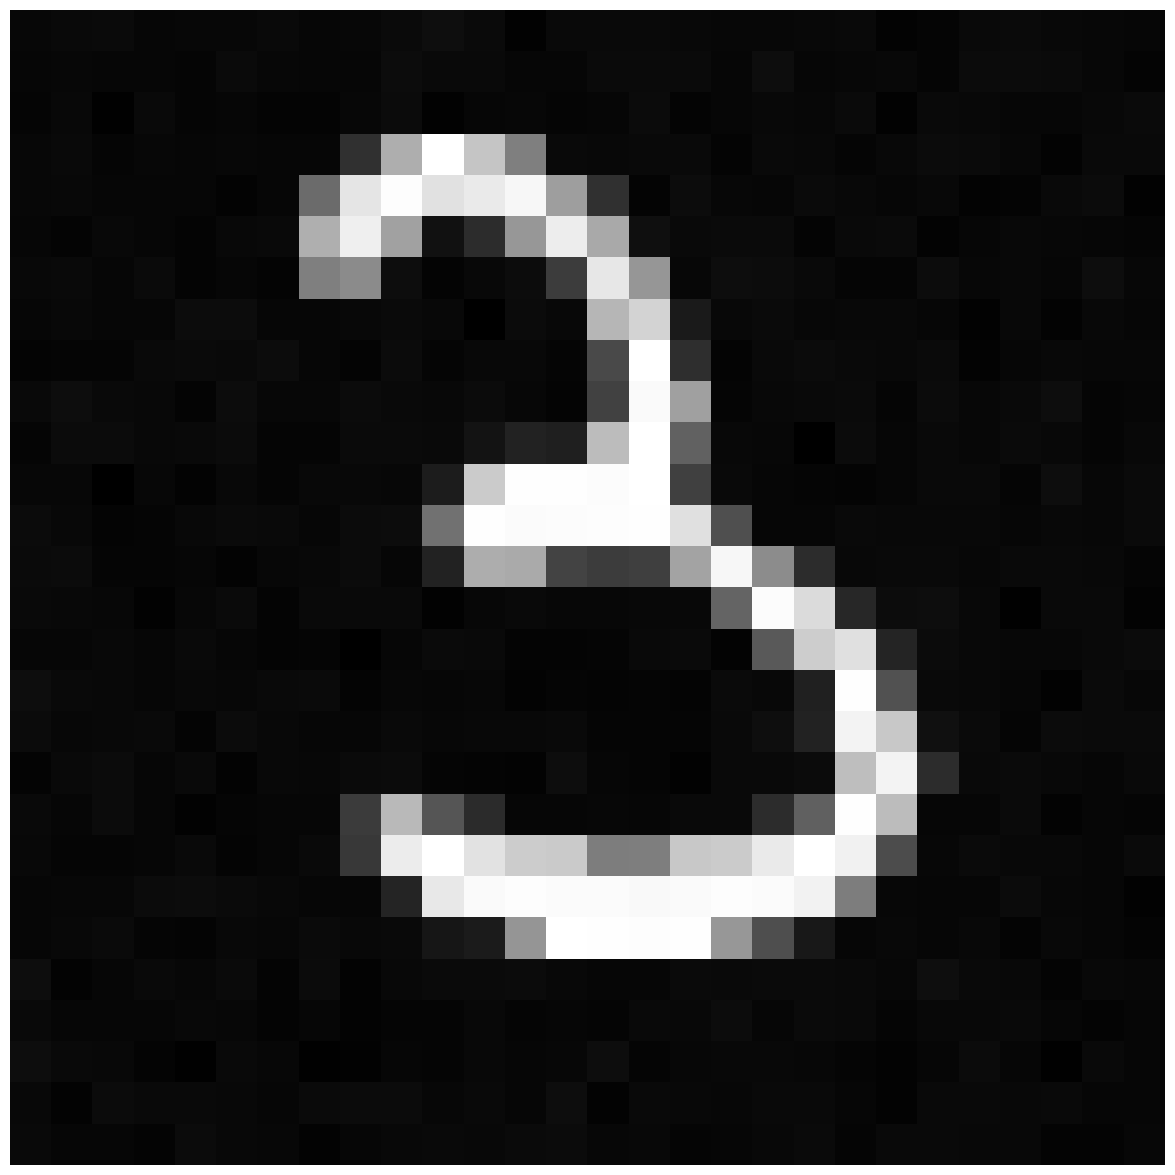

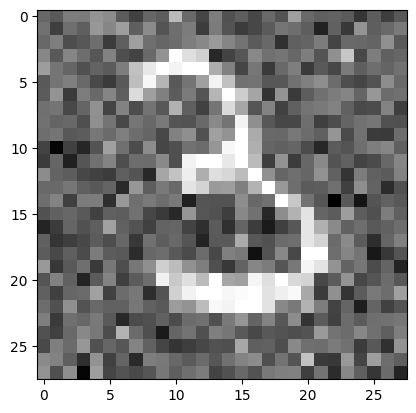

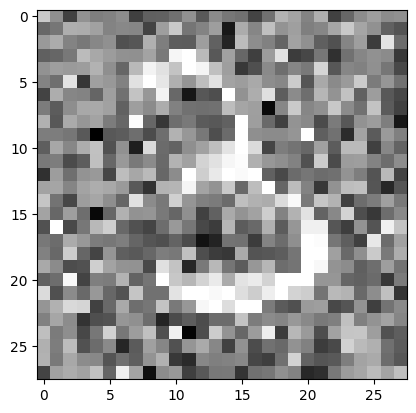

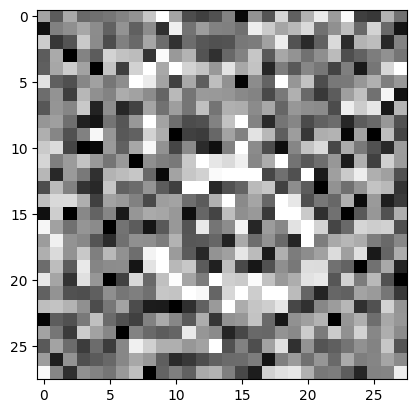

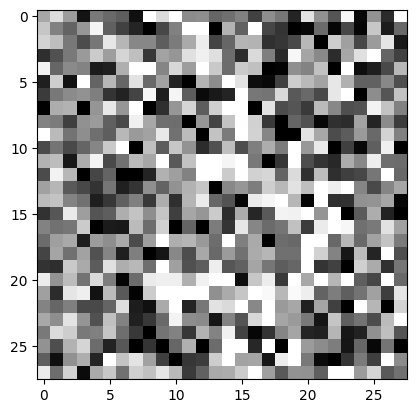

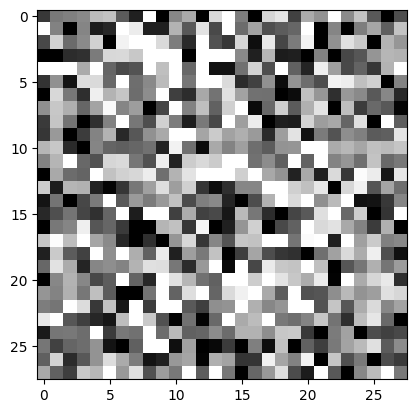

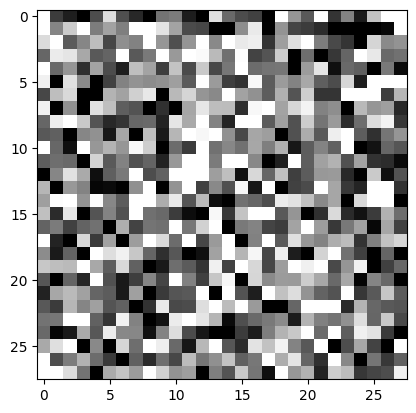

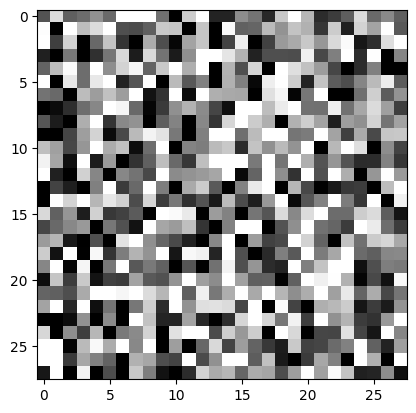

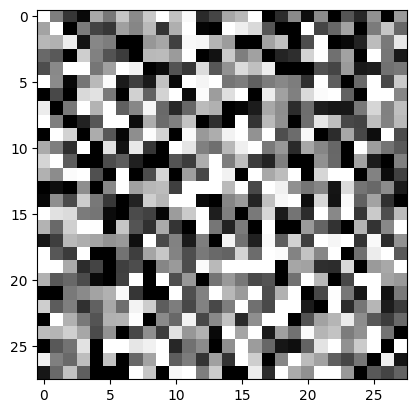

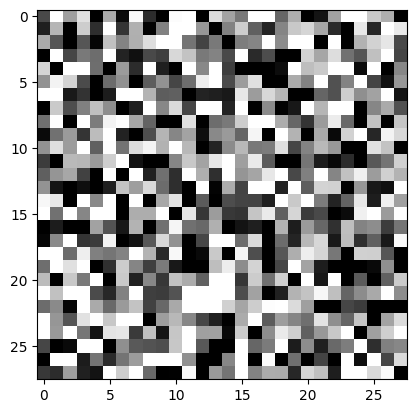

In [ ]:
# Function to display a tensor image
def show_tensor_image(image_tensor):
    # Select the first image in the batch (assuming batch dimension is the first)
    image_tensor = image_tensor[0]
    # Scale tensor values from range [-1, 1] to [0, 1]
    image_tensor = (image_tensor + 1) / 2
    # Clamp values to ensure they are within [0, 1] range after scaling
    image_tensor = image_tensor.clamp(0, 1)
    # Detach tensor from computation graph and move to CPU for visualization
    image_tensor = image_tensor.detach().cpu()
    # Convert tensor to numpy array for plotting
    image = image_tensor.numpy()
    # Reorder dimensions to match (height, width, channels) for visualization
    image = np.transpose(image, (1, 2, 0))
    # Display the image in grayscale mode
    plt.imshow(image, cmap='gray')
    plt.show()

# Simulate the forward diffusion process on an example image
image = next(iter(train_loader))[0]  # Retrieve the first batch of images from the training loader

# Set up the figure for displaying images
plt.figure(figsize=(15,15))  # Define the size of the figure
plt.axis('off')  # Turn off axis display for cleaner visuals

# Define the number of images to display and the stepsize between diffusion steps
num_images = 10  # Number of images to show at different diffusion steps
stepsize = int(T / num_images)  # Calculate the step interval

# Loop through different timesteps to show the diffusion process over time
for idx in range(0, T, stepsize):
    # Create the timestep tensor with the current index
    t = torch.Tensor([idx]).type(torch.int64)

    # Define the subplot position for each diffusion step image
    # plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)

    # Apply forward diffusion to the original image for the current timestep
    img, noise = forward_diffusion_sample(image, t)

    # Display the diffused image at the current timestep
    show_tensor_image(img)


### Backward Diffusion Process

Create a sinusoidal positional embedder to encode a diffusion step

In [ ]:
# Define a sinusoidal positional embedding class for diffusion timesteps
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        # Initialize with the desired embedding dimension
        super().__init__()
        self.dim = dim  # Store the embedding dimension

    def forward(self, x):
        # Get the device of input tensor `x` to ensure embeddings are created on the same device
        device = x.device

        # Calculate half of the embedding dimension
        half_dim = self.dim // 2

        # Calculate the scaling factor for the sinusoidal frequencies
        emb = math.log(10000) / (half_dim - 1)

        # Create the sinusoidal frequency terms as an exponentially increasing series
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)

        # Compute the position embeddings by multiplying `x` with frequency terms
        emb = x[:, None] * emb[None, :]

        # Concatenate sine and cosine embeddings along the last dimension
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)

        return emb  # Return the final positional embedding tensor

Create a simple stacked-convolution model with different dilations instead of a UNet-like architecture for noise prediction

In [ ]:
# Define a convolutional block class, inheriting from nn.Conv2d,
# for flexible layers with options for normalization, activation,
# and residual connections
class ConvBlock(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        activation_fn=None,
        drop_rate=0.,
        stride=1,
        padding='same',
        dilation=1,
        groups=1,
        bias=True,
        gn=False,
        gn_groups=8
    ):

        # Adjust padding if specified as 'same' to ensure output spatial dimensions match input size
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        # Initialize the Conv2d layer with given parameters
        super(ConvBlock, self).__init__(
            in_channels, out_channels, kernel_size, stride=stride,
            padding=padding, dilation=dilation, groups=groups, bias=bias
        )

        # Define activation function as SiLU if specified, otherwise set to None
        self.activation_fn = nn.SiLU() if activation_fn else None

        # Add GroupNorm if specified, with `gn_groups` groups
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None

    def forward(self, x, time_embedding=None, residual=False):
        # Apply residual connection if specified, typically used in diffusion models' U-Net
        if residual:
            # Add the time embedding to `x`, only for residual blocks
            x = x + time_embedding
            y = x
            # Apply convolution to the input `x`
            x = super(ConvBlock, self).forward(x)
            # Add residual connection output to the original input `y`
            y = y + x
        else:
            # Apply the convolution to `x` without a residual connection
            y = super(ConvBlock, self).forward(x)

        # Apply group normalization if it exists
        y = self.group_norm(y) if self.group_norm is not None else y

        # Apply activation function if it exists
        y = self.activation_fn(y) if self.activation_fn is not None else y

        return y  # Return the processed output

Compose a Denoiser model consisting ConvBlocks

In [ ]:
# Define the Denoiser class inheriting from nn.Module, designed for denoising tasks in diffusion models
class Denoiser(nn.Module):

    def __init__(
        self,
        image_resolution,
        hidden_dims=[256, 256],
        diffusion_time_embedding_dim=256,
        n_times=1000
    ):
        super(Denoiser, self).__init__()

        # Extract the number of channels from the image resolution input
        _, _, img_C = image_resolution

        # Define positional embedding for the diffusion timestep
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)

        # Initial convolution to project input image channels to hidden dimensions
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)

        # Define the projection for time embedding, consisting of two ConvBlocks
        self.time_project = nn.Sequential(
            ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),  # First layer projects time embedding to hidden dimension
            ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1)  # Second layer keeps hidden dimension constant
        )

        # Initialize a list to store convolutional layers, starting with the first ConvBlock
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])

        # Append ConvBlocks to `self.convs`, adjusting dilation and GroupNorm based on layer depth
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(
                hidden_dims[idx-1],  # Input channel size of the previous layer
                hidden_dims[idx],    # Output channel size of the current layer
                kernel_size=3,
                dilation=3 ** ((idx-1) // 2),  # Increase dilation as layer depth increases
                activation_fn=True,
                gn=True,             # Apply GroupNorm
                gn_groups=8          # Number of groups for GroupNorm
            ))

        # Define the output projection layer to reduce the hidden dimension to the original number of image channels
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)

    # Define the forward pass of the model
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x  # Initialize `y` with the perturbed image

        # Compute the diffusion time embedding and reshape for compatibility with the network
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))  # Add spatial dimensions

        # Project the input image using the initial convolutional projection
        y = self.in_project(y)

        # Apply each ConvBlock layer in the convolution list, with residual connections and time embedding
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual=True)

        # Apply the final output projection to match the output to the input channel dimensions
        y = self.out_project(y)

        return y  # Return the denoised output

# Instantiate the Denoiser model with specified parameters
denoiser_model = Denoiser(
    image_resolution=img_size,  # Input image size
    hidden_dims=hidden_dims,  # List of hidden dimensions for each ConvBlock layer
    diffusion_time_embedding_dim=timestep_embedding_dim,  # Dimension for timestep embedding
    n_times=n_timesteps       # Total number of timesteps in the diffusion process
).to(device)  # Move model to specified device

### Full Diffusion Model (Forward + Backward)

Compile a diffusion model in a class implementing forward and backward processes

In [ ]:
# Define the Diffusion class inheriting from nn.Module, implementing forward and reverse diffusion processes
class Diffusion(nn.Module):
    def __init__(
        self,
        model,
        image_resolution=[32, 32, 3],
        n_times=1000,
        beta_minmax=[1e-4, 2e-2],
        device='cuda'
    ):

        super(Diffusion, self).__init__()

        # Set the number of timesteps and image resolution
        self.n_times = n_times
        self.img_H, self.img_W, self.img_C = image_resolution

        # Model for predicting the noise at each timestep
        self.model = model

        # Define linear variance schedule (betas) following the DDPM paper
        beta_1, beta_T = beta_minmax
        betas = torch.linspace(start=beta_1, end=beta_T, steps=n_times).to(device)
        self.sqrt_betas = torch.sqrt(betas)

        # Define alphas for forward diffusion kernel and calculate cumulative products for closed-form solutions
        self.alphas = 1 - betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        alpha_bars = torch.cumprod(self.alphas, dim=0)  # Product of alphas over time steps
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)
        self.sqrt_alpha_bars = torch.sqrt(alpha_bars)

        # Device configuration for computations
        self.device = device

    # Utility function to extract the correct index from tensor `a` at timestep `t` with shape `x_shape`
    def extract(self, a, t, x_shape):
        b, *_ = t.shape  # Batch size
        out = a.gather(-1, t)  # Gather values at indices t from a
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))  # Reshape to match x_shape

    # Scale values from [0, 1] to [-1, 1], important for diffusion process training
    def scale_to_minus_one_to_one(self, x):
        return x * 2 - 1

    # Reverse scaling values from [-1, 1] to [0, 1]
    def reverse_scale_to_zero_to_one(self, x):
        return (x + 1) * 0.5

    # Perturb the original image at a specific timestep t, adding noise according to the diffusion process
    def make_noisy(self, x_zeros, t):
        epsilon = torch.randn_like(x_zeros).to(self.device)  # Generate random noise

        sqrt_alpha_bar = self.extract(self.sqrt_alpha_bars, t, x_zeros.shape)  # Extract $\sqrt{\alpha}$ term
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, t, x_zeros.shape)  # Extract $\sqrt{1 - \alpha}$ term
        noisy_sample = x_zeros * sqrt_alpha_bar + epsilon * sqrt_one_minus_alpha_bar  # Combine original and noisy parts

        return noisy_sample.detach(), epsilon  # Return the noisy sample and noise (epsilon)

    # Forward pass for the diffusion model
    def forward(self, x_zeros):
        x_zeros = self.scale_to_minus_one_to_one(x_zeros)  # Normalize input images

        B, _, _, _ = x_zeros.shape  # Batch size

        # (1) Randomly choose a diffusion timestep
        t = torch.randint(low=0, high=self.n_times, size=(B,)).long().to(self.device)

        # (2) Forward diffusion process: perturb the input using the predefined variance schedule
        perturbed_images, epsilon = self.make_noisy(x_zeros, t)

        # (3) Predict epsilon/noise using the model at the selected timestep
        pred_epsilon = self.model(perturbed_images, t)

        return perturbed_images, epsilon, pred_epsilon

    # Denoise at a specific timestep during the reverse diffusion process
    def denoise_at_t(self, x_t, timestep, t):
        B, _, _, _ = x_t.shape

        # If not the final timestep, add noise; otherwise, use zeros
        if t > 1:
            z = torch.randn_like(x_t).to(self.device)
        else:
            z = torch.zeros_like(x_t).to(self.device)

        # Predict noise epsilon at this timestep using the model
        epsilon_pred = self.model(x_t, timestep)

        # Extract terms for denoising calculation based on timestep
        alpha = self.extract(self.alphas, timestep, x_t.shape)
        sqrt_alpha = self.extract(self.sqrt_alphas, timestep, x_t.shape)
        sqrt_one_minus_alpha_bar = self.extract(self.sqrt_one_minus_alpha_bars, timestep, x_t.shape)
        sqrt_beta = self.extract(self.sqrt_betas, timestep, x_t.shape)

        # Denoise x_t at this timestep, using the predicted noise
        x_t_minus_1 = 1 / sqrt_alpha * (x_t - (1 - alpha) / sqrt_one_minus_alpha_bar * epsilon_pred) + sqrt_beta * z

        return x_t_minus_1.clamp(-1., 1)  # Clamp result to keep within range

    # Generate samples by running the reverse diffusion process starting from random noise
    def sample(self, N):
        # Start from a random noise vector x_t (initializing x_0 as x_t for simplicity)
        x_t = torch.randn((N, self.img_C, self.img_H, self.img_W)).to(self.device)

        # Iteratively denoise from x_T to x_0 (initial image)
        for t in range(self.n_times - 1, -1, -1):
            timestep = torch.tensor([t]).repeat_interleave(N, dim=0).long().to(self.device)  # Create timestep tensor for all samples
            x_t = self.denoise_at_t(x_t, timestep, t)

        # Reverse scale x_0 back to range [0, 1]
        x_0 = self.reverse_scale_to_zero_to_one(x_t)

        return x_0

# Instantiate the Diffusion model with the specified parameters and initialize the optimizer and loss function
diffusion_model = Diffusion(
    denoiser_model,                  # Denoiser model for predicting noise
    image_resolution=img_size,       # Image dimensions
    n_times=n_timesteps,             # Number of timesteps for the diffusion process
    beta_minmax=beta_minmax,         # Range for beta schedule
    device=device                    # Device for computation
).to(device)

# Define learning rate and optimizer for training the diffusion model
lr = 5e-5
optimizer = Adam(diffusion_model.parameters(), lr=lr)

# Define Mean Squared Error loss for the denoising process
denoising_loss = nn.MSELoss()

Model training

In [ ]:
# Set the denoiser model to training mode
denoiser_model.train()

# Set the number of training epochs
epochs = 3

# Training loop for each epoch
for epoch in range(epochs):
    noise_prediction_loss = 0  # Initialize loss accumulator for the epoch

    # Loop over each batch in the training data, with progress tracking
    for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):

        optimizer.zero_grad()  # Reset gradients for the optimizer

        x = x.to(device)  # Move input batch to the specified device (e.g., GPU)

        # Forward pass through the diffusion model to get noisy input, ground truth noise, and predicted noise
        noisy_input, epsilon, pred_epsilon = diffusion_model(x)

        # Calculate denoising loss between the predicted and actual noise (MSE)
        loss = denoising_loss(pred_epsilon, epsilon)

        # Accumulate the loss for the current batch
        noise_prediction_loss += loss.item()

        # Backpropagate the loss and update model weights
        loss.backward()
        optimizer.step()

    # Print average denoising loss for the epoch
    print("\t[Epoch", epoch + 1, "]\tDenoising Loss: ", noise_prediction_loss / batch_idx)

100%|██████████| 469/469 [05:27<00:00,  1.43it/s]


	[Epoch 1 ]	Denoising Loss:  0.09937399398121569


100%|██████████| 469/469 [05:29<00:00,  1.42it/s]


	[Epoch 2 ]	Denoising Loss:  0.040150197823810525


100%|██████████| 469/469 [05:29<00:00,  1.43it/s]

	[Epoch 3 ]	Denoising Loss:  0.03520502054140481


Image generation

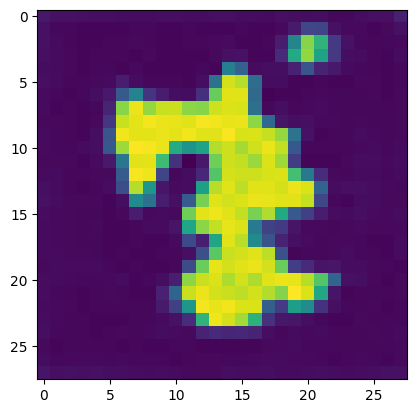

In [ ]:
# Set the denoiser model to evaluation mode
denoiser_model.eval()

# Disable gradient computation for inference to save memory and computation
with torch.no_grad():
    # Generate images by sampling from the diffusion model
    generated_images = diffusion_model.sample(N=10)  # Sample 10 images

# Function to display an image
def show_image(x, idx):
    fig = plt.figure()  # Create a new figure for displaying the image
    # Transpose the image tensor dimensions for proper display and convert to numpy
    plt.imshow(x[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

show_image(generated_images, idx=0)

## Sources

* M. Fahim. Advanced Machine Learning. Lecture 3: Diffusion Models.
* G. Dlamini. Generative Models (Denoising Diffusion Probabilistic Model)
* [Diffusers HF Tutorial](https://huggingface.co/docs/diffusers/en/tutorials/basic_training)